In [35]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.preprocessing import image

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
train_dir = 'drive/MyDrive/Capstone Project/train'
valid_dir = 'drive/MyDrive/Capstone Project/valid'
test_dir = 'drive/MyDrive/Capstone Project/test'

ImageGen

In [37]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  train_datagen = ImageDataGenerator(
                          rescale=1./255,
                          rotation_range=20,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          shear_range=0.2,
                          zoom_range=0.2,
                          horizontal_flip=True,
                          fill_mode='nearest'
)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=10,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(
                          rescale=1./255,
                          rotation_range=20,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          shear_range=0.2,
                          zoom_range=0.2,
                          horizontal_flip=True,
                          fill_mode='nearest'
)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=10,
                                                                class_mode='categorical',
                                                                target_size=(150, 150))
  ### END CODE HERE
  return train_generator, validation_generator

In [38]:
train_generator, validation_generator = train_val_generators(train_dir, valid_dir)

Found 1672 images belonging to 11 classes.
Found 1204 images belonging to 11 classes.


Model

In [39]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dense(11, activation='softmax')
])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 17, 17, 128)      

In [40]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Callbacks

In [41]:
class AccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        current_accuracy = logs.get('accuracy')

        target_accuracy = 0.95

        if current_accuracy is not None and current_accuracy >= target_accuracy:
            print(f"\nReached {target_accuracy * 100}% accuracy. Stopping training.")
            self.model.stop_training = True

#train Model

In [ ]:
history = model.fit(train_generator,
                    epochs=200,
                    validation_data=validation_generator,
                    callbacks=[AccuracyCallback()])

Epoch 1/200
 34/168 [=====>........................] - ETA: 58s - loss: 2.3201 - accuracy: 0.1794

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


168/168 [==============================] - 97s 574ms/step - loss: 2.0746 - accuracy: 0.2644 - val_loss: 1.7185 - val_accuracy: 0.3812
Epoch 2/200
168/168 [==============================] - 78s 464ms/step - loss: 1.6532 - accuracy: 0.3953 - val_loss: 1.4764 - val_accuracy: 0.4734
Epoch 3/200
168/168 [==============================] - 75s 444ms/step - loss: 1.4251 - accuracy: 0.4797 - val_loss: 1.4669 - val_accuracy: 0.4676
Epoch 4/200
 24/168 [===>..........................] - ETA: 42s - loss: 1.3976 - accuracy: 0.5042

#make test_data and test_label

In [25]:
import os
import cv2
import numpy as np
from keras.preprocessing import image
from keras.utils import to_categorical

# Set the path to your test data directory
test_data_directory = 'drive/MyDrive/Capstone Project/test'

# Get the list of class names (assuming subdirectories in test_data_directory are class names)
class_names = sorted(os.listdir(test_data_directory))

# Initialize empty lists to store test data and labels
test_data = []
test_labels = []


# Load and preprocess test data
for class_index, class_name in enumerate(class_names):
    class_path = os.path.join(test_data_directory, class_name)

    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)

        # Load and preprocess the image
        img = image.load_img(file_path, target_size=(150, 150))  # Adjust target_size based on your model's input size
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.imagenet_utils.preprocess_input(img_array)  # Assuming you have a preprocessing function, e.g., from keras.applications import preprocess_input

        # Append the preprocessed image to test_data
        test_data.append(img_array)

        # Append the class index (label) to test_labels
        test_labels.append(class_index)

# Convert lists to numpy arrays
test_data = np.vstack(test_data)
test_labels = np.array(test_labels)

# Convert labels to one-hot encoding (if needed)
test_labels_one_hot = to_categorical(test_labels, num_classes=len(class_names))

# Shuffle the test data and labels (if needed)
indices = np.random.permutation(len(test_data))
test_data = test_data[indices]
test_labels = test_labels[indices]
test_labels_one_hot = test_labels_one_hot[indices]


In [26]:
from keras.preprocessing.image import ImageDataGenerator

# Define the path to your test data directory
test_data_dir = test_dir

# Set the target size based on your model's input size
target_size = (150, 150)

# Create an ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # You can add other preprocessing steps if needed

# Create a test generator
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=32,  # Adjust batch size based on your preference
    class_mode='categorical',  # Set to 'binary' for binary classification
    shuffle=False  # Keep the order of predictions consistent for evaluation
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


Found 110 images belonging to 11 classes.
4/4 [==============================] - 2s 339ms/step - loss: 1.4049 - accuracy: 0.8182
Test Loss: 1.4049310684204102
Test Accuracy: 0.8181818127632141


#Using Confusion Matrix to see the accuracy

4/4 [==============================] - 1s 212ms/step


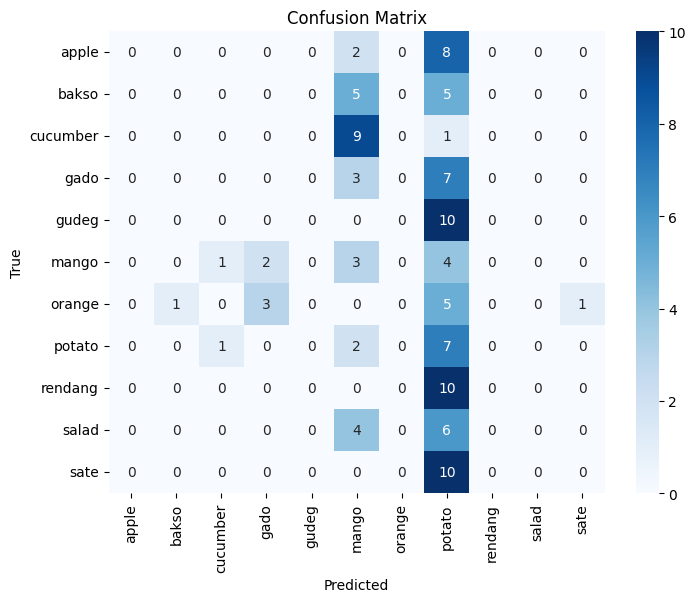


Classification Report:
              precision    recall  f1-score   support

       apple       0.00      0.00      0.00        10
       bakso       0.00      0.00      0.00        10
    cucumber       0.00      0.00      0.00        10
        gado       0.00      0.00      0.00        10
       gudeg       0.00      0.00      0.00        10
       mango       0.11      0.30      0.16        10
      orange       0.00      0.00      0.00        10
      potato       0.10      0.70      0.17        10
     rendang       0.00      0.00      0.00        10
       salad       0.00      0.00      0.00        10
        sate       0.00      0.00      0.00        10

    accuracy                           0.09       110
   macro avg       0.02      0.09      0.03       110
weighted avg       0.02      0.09      0.03       110



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a model that is already trained
# Make predictions on the test data
predictions = model.predict(test_data)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert true labels to class labels (assuming they are integers)
true_labels = test_labels

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))


In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np


# Class labels mapping
class_labels = {
    0: 'apple',
    1: 'bakso',
    2: 'cucumber',
    3: 'gado',
    4: 'gudeg',
    5: 'mango',
    6: 'orange',
    7: 'potato',
    8: 'rendang',
    9: 'salad',
    10: 'sate'
}

# Load and preprocess the input image
img_path = 'drive/MyDrive/Capstone Project/test/bakso/bakso-21931.jpg' # Replace with the path to your image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = class_labels.get(predicted_class_index, 'Unknown')

# Print the predicted class label
print(f"The predicted class label is: {predicted_class_label}")


1/1 [==============================] - 0s 64ms/step
The predicted class label is: potato
